In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from random import randint
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [44]:
df_orginal = pd.read_csv('./Crystal_structure.csv')
df = pd.read_csv('./Crystal_structure.csv')
df.head()

,Compound,A,B,In literature,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ,Lowest distortion
0,Ac2O3,Ac,Ac,False,0,0,1.12,1.12,1.12,1.1,1.10,0.0,0.000000,-3.248000,0.707107,-,0.800000,cubic
1,AcAgO3,Ac,Ag,False,0,0,1.12,1.12,0.95,1.1,1.93,0.0,2.488353,-2.565071,0.758259,-,0.678571,orthorhombic
2,AcAlO3,Ac,Al,False,0,0,1.12,1.12,0.54,1.1,1.61,0.0,1.892894,-1.846714,0.918510,-,0.385714,cubic
3,AcAsO3,Ac,As,False,0,0,1.12,1.12,0.52,1.1,2.18,0.0,1.932227,-1.577429,0.928078,-,0.371429,orthorhombic
4,AcAuO3,Ac,Au,False,0,0,1.12,1.12,0.93,1.1,2.54,0.0,2.313698,-2.279786,0.764768,-,0.664286,orthorhombic


### Data cleaning and pre-processing
#### Unnecessary features
Let's drop "in literature" and 'Compound' fields from df dataframe

In [45]:
df = df.drop(columns=["In literature", 'Compound'])
df.columns

Index(['A', 'B', 'v(A)', 'v(B)', 'r(AXII)(Å)', 'r(AVI)(Å)', 'r(BVI)(Å)',
       'EN(A)', 'EN(B)', 'l(A-O)(Å)', 'l(B-O)(Å)', 'ΔENR', 'tG', 'τ', 'μ',
       'Lowest distortion'],
      dtype='object')

Similarly, the compound name should not be input into the model, as the information it contains is already captured in the A and B fields. The compound name always follows the format "AB" followed by "O3."

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   A                  5329 non-null   object 
 1   B                  5329 non-null   object 
 2   v(A)               5329 non-null   object 
 3   v(B)               5329 non-null   object 
 4   r(AXII)(Å)         5329 non-null   float64
 5   r(AVI)(Å)          5329 non-null   float64
 6   r(BVI)(Å)          5329 non-null   float64
 7   EN(A)              5329 non-null   float64
 8   EN(B)              5329 non-null   float64
 9   l(A-O)(Å)          5329 non-null   float64
 10  l(B-O)(Å)          5329 non-null   float64
 11  ΔENR               5329 non-null   float64
 12  tG                 5329 non-null   float64
 13  τ                  5329 non-null   object 
 14  μ                  5329 non-null   float64
 15  Lowest distortion  5329 non-null   object 
dtypes: float64(10), object(6

#### The first thing we notice is that some fields are filled with dashes (-). How should we handle these? Let's look at them on a case-by-case basis.

In [47]:
(df == "-").any()

,0
A,False
B,False
v(A),True
v(B),True
r(AXII)(Å),False
r(AVI)(Å),False
r(BVI)(Å),False
EN(A),False
EN(B),False
l(A-O)(Å),False


VA and VB are valencies

In [48]:
print(df["v(A)"].unique())
print(df["v(B)"].unique())

['0' '-' '1' '3' '2' '4' '5']
['0' '-' '5' '3' '4' '2' '1']


In [49]:
(df["v(A)"] == "-").sum(), (df["v(B)"] == "-").sum()

(1881, 1881)

In [50]:
((df["v(A)"] == "-").sum() and (df["v(B)"] == "-").sum()).sum()

1881

The number of missing valencies is identical for both the first and second elements. In fact, if we check, we find that these rows are the same: there are 1,881 rows where both \( v(A) \) and \( v(B) \) are undefined.

At this point, we have five possible approaches:

1. Replace all undefined values with zeros. This would likely be incorrect for many compounds.
2. Replace all undefined values with the median value. This doesn't make sense since valencies should be integers.
3. Drop the entire columns. However, this would remove valuable data from the dataset.
4. Drop the entire rows with missing valency values. This would result in losing 35% of the data, which is a significant loss.
5. Treat "Undefined" as a separate value. We could one-hot encode the valencies, with the undefined values still represented in the dataset.



In [51]:
VA_one_hot = pd.get_dummies(df['v(A)'], prefix="v(A)=", prefix_sep="")
VB_one_hot = pd.get_dummies(df['v(B)'], prefix="v(B)=", prefix_sep="")
df = pd.concat([df, VA_one_hot, VB_one_hot], axis=1)

In [52]:
df.head()

,A,B,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),...,v(A)=3,v(A)=4,v(A)=5,v(B)=-,v(B)=0,v(B)=1,v(B)=2,v(B)=3,v(B)=4,v(B)=5
0,Ac,Ac,0,0,1.12,1.12,1.12,1.1,1.10,0.0,...,False,False,False,False,True,False,False,False,False,False
1,Ac,Ag,0,0,1.12,1.12,0.95,1.1,1.93,0.0,...,False,False,False,False,True,False,False,False,False,False
2,Ac,Al,0,0,1.12,1.12,0.54,1.1,1.61,0.0,...,False,False,False,False,True,False,False,False,False,False
3,Ac,As,0,0,1.12,1.12,0.52,1.1,2.18,0.0,...,False,False,False,False,True,False,False,False,False,False
4,Ac,Au,0,0,1.12,1.12,0.93,1.1,2.54,0.0,...,False,False,False,False,True,False,False,False,False,False


In [53]:
# Let's drop the original columns of v(A) and v(B)
df = df.drop(["v(A)", "v(B)"], axis=1)
df.columns

Index(['A', 'B', 'r(AXII)(Å)', 'r(AVI)(Å)', 'r(BVI)(Å)', 'EN(A)', 'EN(B)',
       'l(A-O)(Å)', 'l(B-O)(Å)', 'ΔENR', 'tG', 'τ', 'μ', 'Lowest distortion',
       'v(A)=-', 'v(A)=0', 'v(A)=1', 'v(A)=2', 'v(A)=3', 'v(A)=4', 'v(A)=5',
       'v(B)=-', 'v(B)=0', 'v(B)=1', 'v(B)=2', 'v(B)=3', 'v(B)=4', 'v(B)=5'],
      dtype='object')

In [54]:
df['τ'].value_counts()

,count
τ,
-,3143
4.930235309,6
8.829629905,6
5.345872478,6
4.827582385,5
...,...
4.201909459,1
4.942467893,1
4.229645185,1


#### Let's drop 'τ' as there are too many (-) values

In [55]:
df = df.drop(["τ"], axis=1)
df.columns

Index(['A', 'B', 'r(AXII)(Å)', 'r(AVI)(Å)', 'r(BVI)(Å)', 'EN(A)', 'EN(B)',
       'l(A-O)(Å)', 'l(B-O)(Å)', 'ΔENR', 'tG', 'μ', 'Lowest distortion',
       'v(A)=-', 'v(A)=0', 'v(A)=1', 'v(A)=2', 'v(A)=3', 'v(A)=4', 'v(A)=5',
       'v(B)=-', 'v(B)=0', 'v(B)=1', 'v(B)=2', 'v(B)=3', 'v(B)=4', 'v(B)=5'],
      dtype='object')

This is the target field, so any pre-processing could potentially cause issues. Since the dash ('-') appears in only 53 rows, which accounts for roughly 1% of the data, we can safely remove these rows from the dataset.

However, since our goal is to predict this value, rather than simply deleting these rows, we can save them in a separate dataframe after preprocessing. Once the model is trained, we can predict the missing values for these 53 rows. While there's no way to verify whether the predictions will be accurate or completely off, it's worth trying.

In [56]:
(df["Lowest distortion"] == "-").sum()

53

Let's change categorical columns into numerical as follows:

In [57]:
a_one_hot = pd.get_dummies(df['A'], prefix="A=", prefix_sep="")
b_one_hot = pd.get_dummies(df['B'], prefix="B=", prefix_sep="")
df = pd.concat([df, a_one_hot, b_one_hot], axis=1)

In [58]:
df = df.drop(["A"], axis=1)
df = df.drop(["B"], axis=1)

In [59]:
unknown_df = df[df["Lowest distortion"] == "-"]
df = df.drop(df[df["Lowest distortion"] == "-"].index)

In [60]:
classes = df["Lowest distortion"].unique()
classes

array(['cubic', 'orthorhombic', 'rhombohedral', 'tetragonal'],
      dtype=object)

In [61]:
df["Lowest distortion"] = df["Lowest distortion"].astype('category')
df["Lowest distortion"] = df["Lowest distortion"].cat.codes

In [62]:
X = df.drop(labels=["Lowest distortion"], axis=1)
y = df["Lowest distortion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

##Random Forest algorithm¶


In [63]:
imodel = RandomForestClassifier(n_estimators=1000, random_state=42)
imodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [64]:
from sklearn.metrics import accuracy_score
y_pred = imodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest: {accuracy * 100}%")

Accuracy of the random forest: 78.50378787878788%


## Deep Neural Network

In [65]:
INPUT_SHAPE = [len(X_train.columns)]
BATCH_SIZE = 32
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [66]:
nn_model = tf.keras.Sequential([
              tf.keras.layers.Dense(300, activation='relu', name="1st_layer", input_shape=(INPUT_SHAPE)),
              tf.keras.layers.Dropout(.4, name="1st_drop"),
              tf.keras.layers.Dense(200, activation='relu', name="2nd_layer"),
              tf.keras.layers.Dropout(.4, name="2nd_drop"),
              tf.keras.layers.Dense(100, activation='relu', name="3rd_layer"),
              tf.keras.layers.Dropout(.4, name="3rd_drop"),
              tf.keras.layers.Dense(4, activation='softmax', name="output_layer")
], name="model_1")

nn_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
nn_model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1st_layer (Dense)                    │ (None, 300)                 │          51,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1st_drop (Dropout)                   │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2nd_layer (Dense)                    │ (None, 200)                 │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2nd_drop (Dropout)                   │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3rd_layer (Dense)                    │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3rd_drop (Dropout)                   │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,004 (515.64 KB)

 Trainable params: 132,004 (515.64 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history_1 = nn_model.fit(X_train, y_train,
                      epochs=25,
                      batch_size=32,
                      validation_data=(X_test, y_test),
                      verbose=False)

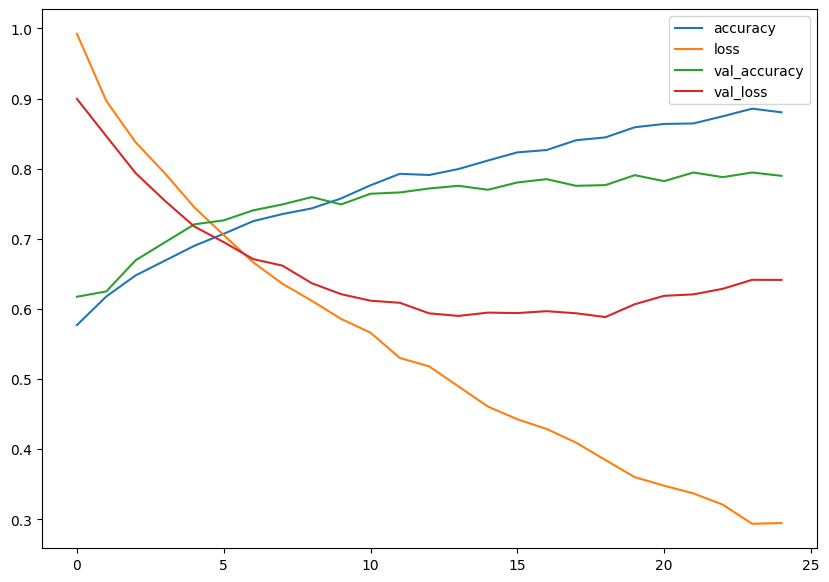

In [69]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [70]:
nn_model.evaluate(X_test, y_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.6717 


[0.6414098739624023, 0.7897727489471436]

In [71]:
features = unknown_df.drop(labels=["Lowest distortion"], axis=1)
predictions = nn_model.predict(features).argmax(axis=1)
prediction_df = pd.DataFrame(columns=["Compound", "Prediction"])
i = 0
for row in features.iterrows():
    row_index = row[0]
    item_dict = {'Compound': [df_orginal.iloc[row_index]["Compound"]], 'Prediction': [classes[predictions[i]]]}
    item = pd.DataFrame(item_dict)
    prediction_df = pd.concat([prediction_df, item], ignore_index=True)
    i += 1

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step


In [72]:
prediction_df

,Compound,Prediction
0,Ca2O3,cubic
1,CeCsO3,cubic
2,CoCsO3,rhombohedral
3,CrCsO3,cubic
4,CsCoO3,tetragonal
5,CsCrO3,tetragonal
6,CsMnO3,tetragonal
7,CsNiO3,tetragonal
8,DyCsO3,cubic
9,FeInO3,cubic
